Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [6]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.296704
Minibatch accuracy: 0.0%
Validation accuracy: 10.0%
Minibatch loss at step 50: 0.820808
Minibatch accuracy: 81.2%
Validation accuracy: 61.8%
Minibatch loss at step 100: 1.483703
Minibatch accuracy: 56.2%
Validation accuracy: 70.2%
Minibatch loss at step 150: 0.609771
Minibatch accuracy: 87.5%
Validation accuracy: 75.2%
Minibatch loss at step 200: 0.549076
Minibatch accuracy: 81.2%
Validation accuracy: 77.6%
Minibatch loss at step 250: 0.819783
Minibatch accuracy: 87.5%
Validation accuracy: 78.7%
Minibatch loss at step 300: 0.933487
Minibatch accuracy: 68.8%
Validation accuracy: 79.7%
Minibatch loss at step 350: 0.532366
Minibatch accuracy: 87.5%
Validation accuracy: 79.4%
Minibatch loss at step 400: 0.941574
Minibatch accuracy: 68.8%
Validation accuracy: 78.2%
Minibatch loss at step 450: 0.764719
Minibatch accuracy: 81.2%
Validation accuracy: 79.9%
Minibatch loss at step 500: 0.534864
Minibatch accuracy: 93.8%
Validation accuracy: 80.8%
Mi

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [42]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    
    hidden = tf.nn.relu(conv + layer1_biases)
    conv=tf.nn.max_pool(hidden,[1, 2, 2, 1], [1, 2, 2, 1], 'SAME' )
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    
    hidden = tf.nn.relu(conv + layer2_biases)
    conv=tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [43]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 3.098638
Minibatch accuracy: 18.8%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.775359
Minibatch accuracy: 43.8%
Validation accuracy: 41.9%
Minibatch loss at step 100: 0.772130
Minibatch accuracy: 75.0%
Validation accuracy: 70.7%
Minibatch loss at step 150: 0.390547
Minibatch accuracy: 87.5%
Validation accuracy: 70.7%
Minibatch loss at step 200: 0.894594
Minibatch accuracy: 68.8%
Validation accuracy: 76.2%
Minibatch loss at step 250: 0.295256
Minibatch accuracy: 93.8%
Validation accuracy: 78.1%
Minibatch loss at step 300: 1.021670
Minibatch accuracy: 68.8%
Validation accuracy: 79.1%
Minibatch loss at step 350: 0.496357
Minibatch accuracy: 75.0%
Validation accuracy: 79.5%
Minibatch loss at step 400: 0.619051
Minibatch accuracy: 81.2%
Validation accuracy: 80.4%
Minibatch loss at step 450: 0.771524
Minibatch accuracy: 75.0%
Validation accuracy: 79.8%
Minibatch loss at step 500: 0.784006
Minibatch accuracy: 81.2%
Validation accuracy: 80.9%
M

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


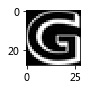

In [26]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(train_dataset))
image = train_dataset[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(train_labels[0])

In [29]:
from sklearn.utils import shuffle

train_dataset, train_labels = shuffle(train_dataset, train_labels)

In [40]:
from tensorflow.contrib.layers import flatten
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  # Model.
  def model(data):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    layer_depth = {
        'layer_1' : 6,
        'layer_2' : 16,
        'layer_3' : 120,
        'layer_f1' : 84
    }

    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,6],mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(data,conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
    # TODO: Activation.
    conv1 = tf.nn.relu(conv1)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,6,16], mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
    # TODO: Activation.
    conv2 = tf.nn.relu(conv2)

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc1 = flatten(pool_2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_w = tf.Variable(tf.truncated_normal(shape = (256,120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1,fc1_w) + fc1_b

    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, 0.5)
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_w = tf.Variable(tf.truncated_normal(shape = (120,84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_w) + fc2_b
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, 0.5)
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_w = tf.Variable(tf.truncated_normal(shape = (84,10), mean = mu , stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(10))
    logits = tf.matmul(fc2, fc3_w) + fc3_b
    return logits
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  global_step = tf.Variable(0)  # count the number of steps taken.
  learning_rate = tf.train.exponential_decay(0.05, global_step,10000, 0.96)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
  # Optimizer.

  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

In [44]:
num_steps = 1001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    train_dataset, train_labels = shuffle(train_dataset, train_labels)
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 4.271773
Minibatch accuracy: 6.2%
Validation accuracy: 10.0%
Minibatch loss at step 50: 1.181499
Minibatch accuracy: 68.8%
Validation accuracy: 56.3%
Minibatch loss at step 100: 1.573582
Minibatch accuracy: 62.5%
Validation accuracy: 67.3%
Minibatch loss at step 150: 0.374918
Minibatch accuracy: 93.8%
Validation accuracy: 76.5%
Minibatch loss at step 200: 0.381732
Minibatch accuracy: 93.8%
Validation accuracy: 76.7%
Minibatch loss at step 250: 0.195306
Minibatch accuracy: 100.0%
Validation accuracy: 79.6%
Minibatch loss at step 300: 0.370074
Minibatch accuracy: 93.8%
Validation accuracy: 78.9%
Minibatch loss at step 350: 0.805332
Minibatch accuracy: 75.0%
Validation accuracy: 79.2%
Minibatch loss at step 400: 1.283620
Minibatch accuracy: 62.5%
Validation accuracy: 80.5%
Minibatch loss at step 450: 0.782248
Minibatch accuracy: 81.2%
Validation accuracy: 78.8%
Minibatch loss at step 500: 0.551024
Minibatch accuracy: 87.5%
Validation accuracy: 81.0%
M